In [1]:
%matplotlib inline

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#read in state boundary
# state = gpd.read_file('https://gis.ne.gov/Enterprise/rest/services/boundaries/FeatureServer/17/query?where=1%3D1&outFields=*&outSR=4326&f=json')
state = gpd.read_file('.\shapefiles\state.shp')
state = state.set_crs("epsg:2163", allow_override=True) #3606

#read in data
in_df = pd.read_csv('.\data\pos_locations_ready.csv')
in_df['ID'] = in_df.index

#drop locations without values
in_df = in_df[in_df['loc'].notnull()]

# filter out those with no bed counts
# in_df = in_df.loc[in_df['bed_cnt'] > 0]

#create geodataframe with POS point data
df = gpd.GeoDataFrame(in_df, geometry=gpd.points_from_xy(in_df['longitude'], in_df['latitude'], crs='EPSG:4326'))
df = df.set_crs('epsg:2163', allow_override=True)

#clip POS locations to Nebraska
df = gpd.clip(df, state)

# Bring in Core based statistical areas
cbsa = gpd.read_file('https://opendata.arcgis.com/datasets/b0d0e777e2ad4b53803dbc0527c73d88_0.geojson')
cbsa = cbsa[['NAMELSAD', 'LSAD', 'geometry']]
cbsa = cbsa.set_crs("epsg:2163", allow_override=True)
cbsa = gpd.clip(cbsa, state)

#spatial join to get NAMESLAD and LSAD to df
df = gpd.sjoin(df, cbsa, how="left")

# Create rural polygons
df.loc[df['NAMELSAD'].isna(), ["NAMELSAD"]] = 'Rural'
df.loc[df['LSAD'].isna(), ["LSAD"]] = 'Rural'

In [3]:
# add census tracts
ct = gpd.read_file(".\\shapefiles\\tl_2019_31_tract.shp")

# add census tract data, configured GEOID, drop column
ct_data = pd.read_csv(".\\data\\ACSST5Y2019.S2801_data_with_overlays_2021-03-20T113931.csv")
ct_data["GEOID"] = ct_data['GEO_ID'].str.slice(start=9)

# join data to census tracts
ct = ct.merge(ct_data, on="GEOID", how='left')

# set ct crs
ct = ct.set_crs("epsg:2163", allow_override=True)

In [4]:
# set up buffer distance
df.loc[df.LSAD.isin(["M1", "M2"]),['buffdist']] = 1000
df.loc[df.LSAD.isin(['Rural']), ['buffdist']] = 10000

#buffer function
def buffer(row):
     return row.geometry.buffer(row.buffdist/111120)

# buffer the POS
###scaled based on checking using Arcgis Pro of 111,120:1###
df_buff = df.copy()
df_buff['geometry'] = df_buff.apply(buffer, axis=1)

# bring in stats that intersect with buffered ct to original df #
# set id column
id_col = 'ID'

#intersect ct and df_buff
intersect = gpd.overlay(ct, df_buff, how='intersection')

#cast columns to numeric
intersect['S2801_C01_011E'] = pd.to_numeric(intersect['S2801_C01_011E'])
intersect['S2801_C01_019E'] = pd.to_numeric(intersect['S2801_C01_019E'])
intersect['S2801_C01_001E'] = pd.to_numeric(intersect['S2801_C01_001E'])
intersect['S2801_C01_013E'] = pd.to_numeric(intersect['S2801_C01_013E'])
intersect['S2801_C01_014E'] = pd.to_numeric(intersect['S2801_C01_014E'])
intersect['S2801_C01_015E'] = pd.to_numeric(intersect['S2801_C01_015E'])

# # #groupby the id_col and sum stats
stats = intersect.groupby(id_col)[['S2801_C01_011E', 'S2801_C01_019E', 'S2801_C01_013E', 'S2801_C01_014E', 'S2801_C01_015E', 'S2801_C01_001E']].sum() #Sum per id_col

# # # populate df columns
df[['tot_no_comp', 'tot_no_int', 'tot_dial', 'tot_broad', 'tot_cell', 'tot_hous']] = stats

#calculate percentages
df['per_no_comp'] = df['tot_no_comp']/df['tot_hous']
df['per_no_int'] = df['tot_no_int']/df['tot_hous']
df['per_dial'] = df['tot_dial']/df['tot_hous']
df['per_broad'] = df['tot_broad']/df['tot_hous']
df['per_cell'] = df['tot_cell']/df['tot_hous']


In [5]:
#group stats
comp = df.groupby("LSAD")[['per_no_int', "per_no_comp", 'per_dial', 'per_broad', 'per_cell']].mean()
comp

,per_no_int,per_no_comp,per_dial,per_broad,per_cell
LSAD,,,,,
M1,0.188246,0.119607,0.005234,0.806519,0.641108
M2,0.204640,0.131282,0.006372,0.788988,0.626233
Rural,0.231177,0.145760,0.007727,0.761096,0.578448


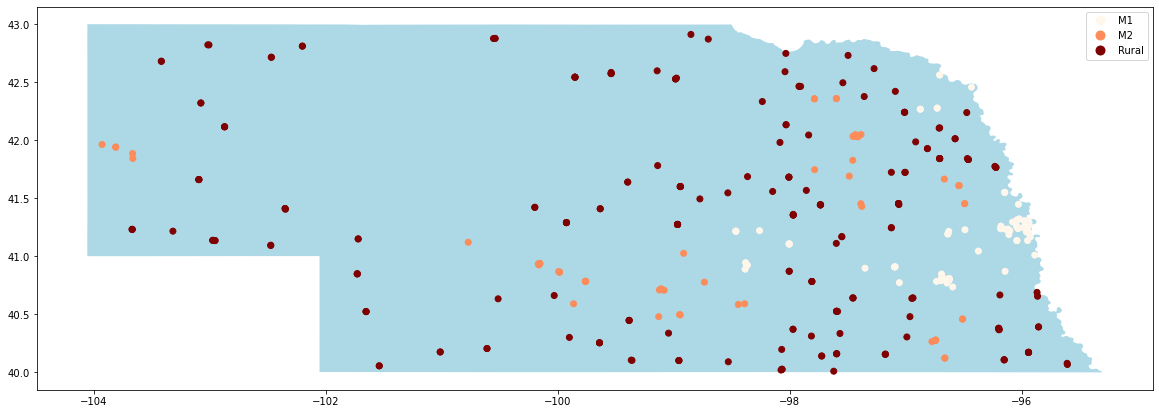

In [13]:
# Map of labels
f, ax = plt.subplots(1, figsize=(20, 30))
state.plot(ax=ax, facecolor='lightblue')
df.plot(ax=ax, column="LSAD", cmap='OrRd', legend=True)
f.suptitle='CBSA'

# Save plot
# plt.savefig('CBSA.png', orientation='landscape')

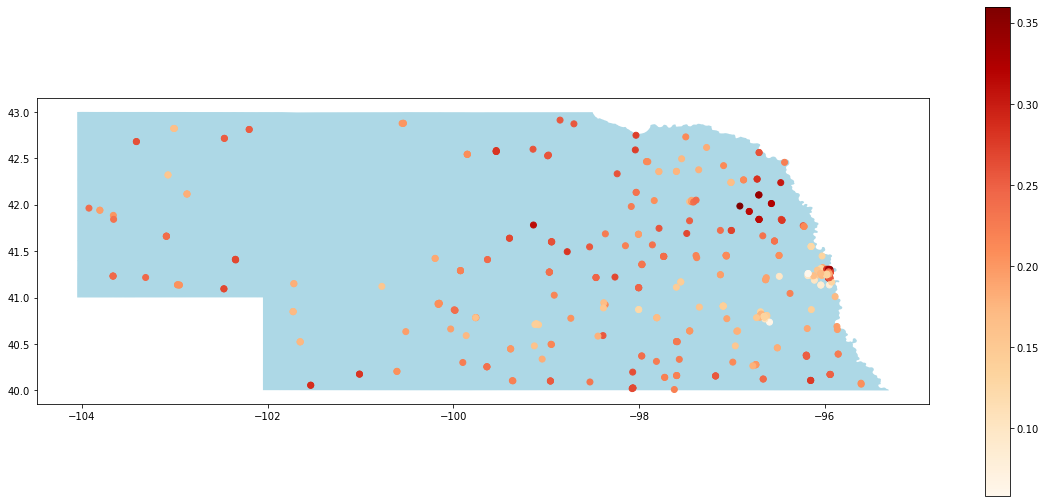

In [69]:
# Map of percent no internet
f, ax = plt.subplots(1, figsize=(20, 30))
state.plot(ax=ax, facecolor='lightblue')
df.plot(ax=ax, column="per_no_int", cmap='OrRd', legend=True, legend_kwds={'shrink': 0.3})
f.suptitle='Percent No Internet'

# Save plot
# plt.savefig('PercentNoInternetMap.png', orientation='landscape')

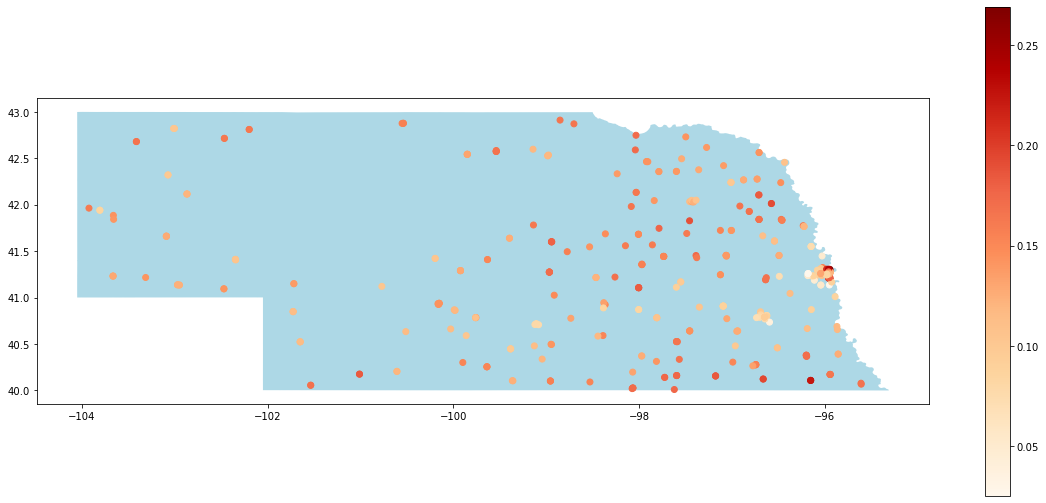

In [15]:
# Map of percent no internet
f, ax = plt.subplots(1, figsize=(20, 30))
state.plot(ax=ax, facecolor='lightblue')
df.plot(ax=ax, column="per_no_comp", cmap='OrRd', legend=True, legend_kwds={'shrink': 0.3})
f.suptitle='Percent No Computer'

# Save plot
# plt.savefig('PercentNoComputerMap.png', orientation='landscape')

In [38]:
#create pandas dataframe for extended plots
pdf = pd.DataFrame(df)

In [ ]:
# no computer histogram - M2
pdf['per_no_comp'].loc[pdf['LSAD'] == 'M2'].plot(kind='hist', title = 'M2')

In [ ]:
# no computer histogram - rural
pdf['per_no_comp'].loc[pdf['LSAD'] == 'Rural'].plot(kind='hist', title = 'Rural')

In [ ]:
# scatter plot
colors = {'M1':'red', 'M2':'blue', 'Rural':'green'}
pdf.plot(x='tot_no_comp', y='tot_hous', kind='scatter', c=df['LSAD'].apply(lambda x: colors[x]), figsize=(10, 10), legend=True)

In [ ]:
# no computer kde
f, ax = plt.subplots(1, figsize=(15, 15))
pdf['per_no_comp'].loc[pdf['LSAD'] == 'M1'].plot(kind='kde', label = 'M1', legend=True, title='Percent No Computers')
pdf['per_no_comp'].loc[pdf['LSAD'] == 'M2'].plot(kind='kde', label = 'M2', legend=True)
pdf['per_no_comp'].loc[pdf['LSAD'] == 'Rural'].plot(kind='kde', label = 'Rural', legend=True)
plt.savefig('PercentNoComputers.png')

In [ ]:
# no internet kde
f, ax = plt.subplots(1, figsize=(15, 15))
pdf['per_no_int'].loc[pdf['LSAD'] == 'M1'].plot(kind='kde', label = 'M1', legend=True, title='Percent No Internet')
pdf['per_no_int'].loc[pdf['LSAD'] == 'M2'].plot(kind='kde', label = 'M2', legend=True)
pdf['per_no_int'].loc[pdf['LSAD'] == 'Rural'].plot(kind='kde', label = 'Rural', legend=True)
plt.savefig('PercentNoInternet.png')

In [55]:
# find 30 highest no internet access providers of service
low30int = pdf.nlargest(30, 'per_no_int')
low30intstats = low30int.groupby('LSAD')['per_no_int'].count()
print('Counts of 30 highest rates of no internet', low30intstats)

# find 30 highest no computers and count
low30comp = pdf.nlargest(30, 'per_no_comp')
low30compstats = low30comp.groupby('LSAD')['per_no_comp'].count()
print('Counts of 30 highest rates of no computer', low30compstats)

Counts of 30 highest rates of no internet LSAD
M1       10
Rural    20
Name: per_no_int, dtype: int64
Counts of 30 highest rates of no computer LSAD
M1       15
M2        3
Rural    12
Name: per_no_comp, dtype: int64
